In [ ]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plot
import torch.nn.functional as F

In [ ]:
from datetime import datetime
import torchvision.transforms as transforms

In [ ]:
train_dataset = torchvision.datasets.CIFAR10(
    root='.',
    train=True,
    transform=transforms.ToTensor(),
    download=True
)

test_data = torchvision.datasets.CIFAR10(
    root='.',
    train=False,
    transform=transforms.ToTensor(),
    download=True
)

100%|██████████| 170M/170M [00:06<00:00, 28.0MB/s]


In [ ]:
K = len(set(train_dataset.targets))08

In [ ]:
K08

10

In [ ]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    shuffle=True,
    batch_size=batch_size
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_data,
    batch_size=batch_size
)

In [ ]:
class CNN(nn.Module):
  def __init__(self, K) -> None:
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2)

    self.fc1 = nn.Linear(128 * 3 * 3, 1024)
    self.fc2 = nn.Linear(1024, K)

  def forward(self, X):
    out = F.relu(self.conv1(X))
    out = F.relu(self.conv2(out))
    out = F.relu(self.conv3(out))
    out = out.view(-1, 128 * 3 * 3)
    out = F.dropout(out, p=0.5)
    out = F.relu(self.fc1(out))
    out = F.dropout(out, p=0.3)
    out = self.fc2(out)
    return out


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available else "cpu")
model = CNN(K)
model.to(device)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
  (fc1): Linear(in_features=1152, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=10, bias=True)
)

In [ ]:

def batch_gd(model: nn.Module, criterion: nn.MSELoss, optimizer: torch.optim.Adam, train_loader, test_loader, epochs):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for it in range(epochs):
    model.train()
    t_0 = datetime.now()
    train_loss = []
    for inputs, targets in train_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, targets)

      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    train_loss = np.mean(train_loss)

    dt = datetime.now() - t_0

    model.eval()
    test_loss = []
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)


      outputs = model(inputs)
      loss = criterion(outputs, targets)

      test_loss.append(loss.item())

    test_loss = np.mean(test_loss)

    train_losses[it] = train_loss
    test_losses[it] = test_loss

    print(f"Epoch: {it}/{epochs}, Train loss: {train_loss:.4f}, Test loss {test_loss:.4f}")
    print(f"Train time {dt}")

  return train_losses, test_losses


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
epochs = 16
train_losses, test_losses = batch_gd(model, criterion, optimizer, train_loader, test_loader, epochs)

Epoch: 0/16, Train loss: 1.7134, Test loss 1.4847
Train time 0:00:10.203852
Epoch: 1/16, Train loss: 1.3989, Test loss 1.3964
Train time 0:00:08.968317
Epoch: 2/16, Train loss: 1.2824, Test loss 1.2439
Train time 0:00:08.925951
Epoch: 3/16, Train loss: 1.2008, Test loss 1.1866
Train time 0:00:08.567195
Epoch: 4/16, Train loss: 1.1347, Test loss 1.1379
Train time 0:00:08.155206
Epoch: 5/16, Train loss: 1.0704, Test loss 1.1174
Train time 0:00:08.869828
Epoch: 6/16, Train loss: 1.0260, Test loss 1.1335
Train time 0:00:08.829599
Epoch: 7/16, Train loss: 0.9931, Test loss 1.0759
Train time 0:00:08.825406
Epoch: 8/16, Train loss: 0.9472, Test loss 1.0769
Train time 0:00:08.910436
Epoch: 9/16, Train loss: 0.9167, Test loss 1.0546
Train time 0:00:08.150173
Epoch: 10/16, Train loss: 0.8927, Test loss 1.0470
Train time 0:00:08.138778
Epoch: 11/16, Train loss: 0.8542, Test loss 1.0464
Train time 0:00:08.638840
Epoch: 12/16, Train loss: 0.8247, Test loss 1.0796
Train time 0:00:08.651959
Epoch: 13

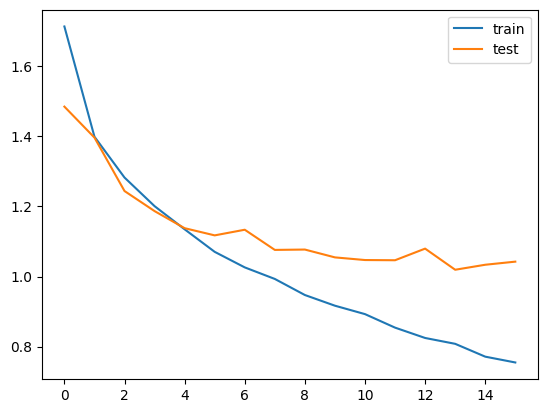

In [ ]:
plot.plot(train_losses, label="train")
plot.plot(test_losses, label='test')
plot.legend()
plot.show()

In [ ]:
n_correct = 0.
n_total = 0.
for inputs, targets in train_loader:
  inputs, targets = inputs.to(device), targets.to(device)


  outputs = model(inputs)
  _, predictions = torch.max(outputs, 1)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

train_acc = n_correct / n_total

for inputs, targets in test_loader:
  inputs, targets = inputs.to(device), targets.to(device)

  outputs = model(inputs)
  _, predictions = torch.max(outputs, 1)

  n_correct += (predictions == targets).sum().item()
  n_total += targets.shape[0]

test_acc = n_correct / n_total

print(f"Train acc: {train_acc:.4f} Test acc: {test_acc:.4f}")

Train acc: 0.7426 Test acc: 0.7271


In [ ]:


from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title="COnfusion Matrix",
                          cmap=plot.cm.Blues
                          ):
  if normalize:
    cm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized")
  else:
    print("Not Normalized")
  print(cm)

  plot.imshow(cm, interpolation="nearest", cmap=cmap)
  plot.title(title)
  tick_marks = np.arange(len(classes))
  plot.xticks(tick_marks, classes, rotation=45)
  plot.xticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plot.text(j, i, format(cm[i,j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

  plot.tight_layout()
  plot.ylabel("True Label")
  plot.xlabel("Predicted Label")
  plot.show()

Not Normalized
[[712  29  55  24  17   4  13   8 101  37]
 [ 21 751  11  14   6   3  12   1  47 134]
 [ 78  10 501 117  86  60  81  24  21  22]
 [ 21  11  73 519  49 139 104  27  21  36]
 [ 35   8  93  82 508  55 123  73  12  11]
 [ 19   9  49 255  43 500  45  42  21  17]
 [  9  12  38  86  24  22 784   6   6  13]
 [ 26   4  40  72  72  67  23 642   6  48]
 [ 64  34  10  17   9   6   7   0 832  21]
 [ 38  98  12  24   3   7  18  11  64 725]]


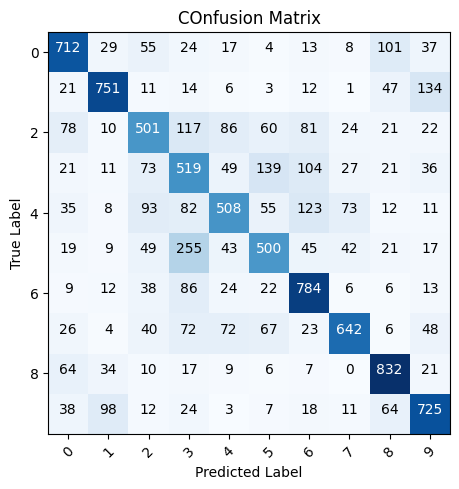

In [ ]:
x_test = test_data.data
y_test = test_data.targets

p_test = np.array([])

for inputs, targets in test_loader:
  inputs = inputs.to(device)

  outputs = model(inputs)

  _, predictions = torch.max(outputs, 1)

  p_test = np.concatenate((p_test, predictions.cpu().numpy()))

cm = confusion_matrix(y_test, p_test)
plot_confusion_matrix(cm, list(range(10)))